In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline

from graphviz  import Source
from IPython.display import SVG, display, HTML
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>" 

In [2]:
train = pd.read_csv('titanic/train.csv')

In [3]:
test = pd.read_csv('titanic/test.csv')

In [4]:
X = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'Fare'], axis = 1)
y = train['Survived']

In [5]:
X = pd.get_dummies(X)

In [9]:
X.isnull().mean()

Pclass        0.0
Age           0.0
SibSp         0.0
Parch         0.0
Sex_female    0.0
Sex_male      0.0
Embarked_C    0.0
Embarked_Q    0.0
Embarked_S    0.0
dtype: float64

In [8]:
# здесь заполним пропущенные значения возрастов медианным значением:
X['Age'] = X['Age'].fillna(X['Age'].median())

In [6]:
# Создаем дерево и обучаем его

clf = tree.DecisionTreeClassifier(criterion = 'entropy')

In [10]:
clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy')

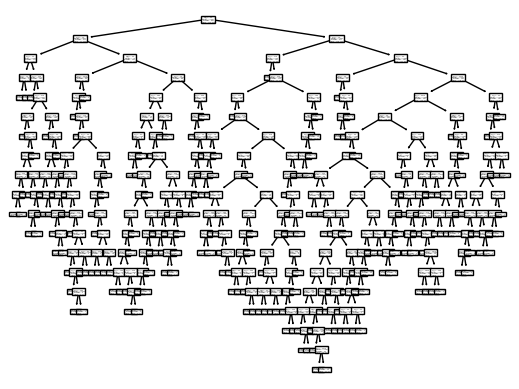

In [11]:
# Рисуем дерево

tree.plot_tree(clf);

In [12]:
# это пример переобучения модели. модель не решает задачу научиться классифицировать на 1 и 0
# здесь модель снижает энтропию до минимума пока не достигнит его

# это есть проблема переобучения, когда вместо того чтобы выявить общую закономерность, обобщить данные
# мы пытаемся безошибочно классифицировать каждое наблюдение в выборке:

# так можно посмотреть долю правильных ответов в нашей выборке:

clf.score(X,y)

0.936026936026936

In [106]:
# как бороться с проблемой переобучения:

# глубина обучения - сколько вопросов может задать дерево, чтобы наилучшим образом классифицировать

# или показывать два набора данных - обучающую и тестовую выборку:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [107]:
# обучим модель на train:

clf.fit(X_train, y_train)

# и выведем точность этого обучения:
clf.score(X_train, y_train)

0.8355704697986577

In [108]:
# а теперь проверим эту модель на тех данных, которые этот классификатор не видел: X_test

clf.score(X_test, y_test)

0.8067796610169492

In [109]:
# самый простой способ избежать проблему переобучения - задать дереву максимальную глубину

clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=5)

In [111]:
# обучим классификатор на train

clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

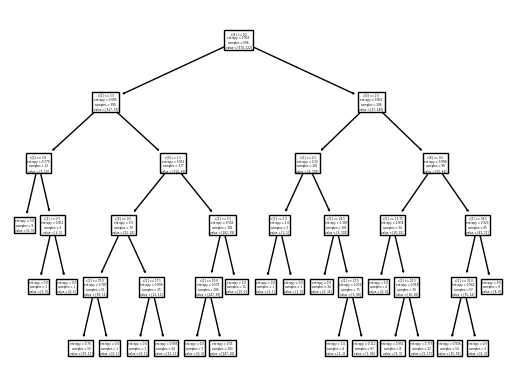

In [17]:
# теперь дерево содержит заданной количество = 5 уровней:

tree.plot_tree(clf);

In [112]:
# видим что классификатор стал работать хуже на train (в прошлый раз было 94% правильных ответов)
clf.score(X_train, y_train)

0.8523489932885906

In [113]:
# зато на тестовых данных - которых классификатор не видел - он стал работать лучше (в прошлый раз было 74% правильных ответов)
clf.score(X_test, y_test)

0.7932203389830509

# Обучение_переобучение_недообучение_кросвалидация

In [114]:
# Заводим пустой итоговый датафрейм в который будем собирать глубины и скоры:

scores_data = pd.DataFrame()

In [115]:
max_depth_values = range(1, 100)

In [118]:
for depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=depth)
    clf.fit(X_train,y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    # создаем строчку для итогового датафрейма:
    temp_scores_data = pd.DataFrame({'max_depth': [depth],  'train_score': [train_score], 'test_score': [test_score]})
    
    # добавляем в итоговый датафрейм:
    scores_data = pd.concat([scores_data, temp_scores_data])

In [119]:
scores_data

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.832215,0.806780
0,4,0.835570,0.806780
0,5,0.852349,0.793220
...,...,...,...
0,95,0.944631,0.749153
0,96,0.944631,0.732203
0,97,0.944631,0.735593
0,98,0.944631,0.735593


In [120]:
# функция melt преобразует итоговый датафрейм

scores_data = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
        var_name='type_score', value_name='score')

scores_data


,max_depth,type_score,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.832215
3,4,train_score,0.835570
4,5,train_score,0.852349
...,...,...,...
391,95,test_score,0.749153
392,96,test_score,0.732203
393,97,test_score,0.735593
394,98,test_score,0.735593


<Axes: xlabel='max_depth', ylabel='score'>

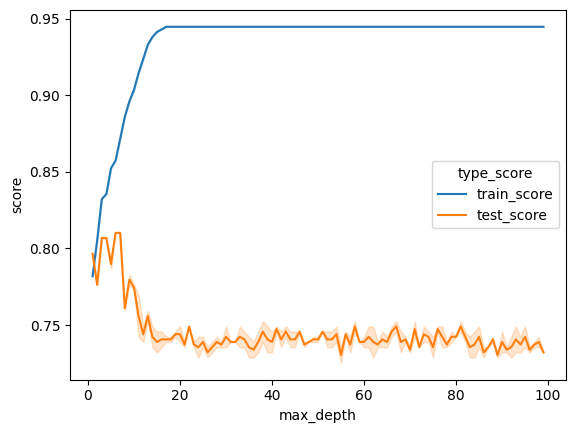

In [121]:
# визуализируем этот датафрейм:

sns.lineplot(data = scores_data, 
             x=scores_data['max_depth'], 
             y=scores_data['score'], 
             hue = 'type_score', 
             #style="type_score", 
             legend='full')


# Кросс валидация

In [ ]:
# Проблема данных заключается в том что мы один раз зафитили модель и больше не меняли набор данных

In [82]:
from sklearn.model_selection import cross_val_score

In [123]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)

In [124]:
# кросс валидация на пяти фолдах только на выборке train:
# показана точность для валидационной части каждого фолда

cross_val_score(clf, X_train, y_train, cv = 5)

array([0.78333333, 0.86554622, 0.7394958 , 0.75630252, 0.86554622])

In [125]:
# из этих значений можно получить среднее для модели: на кросс валидации
cross_val_score(clf, X_train, y_train, cv = 5).mean()

0.8003641456582633

In [ ]:
# теперь в итоговый датафрейм будем добавлять средние данные кросс валидации:

In [141]:
# Заводим пустой итоговый датафрейм в который будем собирать глубины и скоры:

scores_data = pd.DataFrame()

In [142]:
# определяем диапазон глубин обучения:
max_depth_values = range(1, 100)

In [143]:
for depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=depth)
    clf.fit(X_train,y_train)
    
    # получаем train_score:
    train_score = clf.score(X_train, y_train)
    
    # получаем test_score:
    test_score = clf.score(X_test, y_test)
    
    # И ЕЩЕ ДОБАВЛЯЕМ cross_val_score ДЛЯ КАЖДОЙ ГЛУБИНЫ ДЕРЕВА CLF:
    cross_val = cross_val_score(clf, X_train, y_train, cv = 5).mean()
    
    
    # создаем строчку для итогового датафрейма:
    temp_scores_data = pd.DataFrame({'max_depth': [depth],
                                     'train_score': [train_score],
                                     'test_score': [test_score],
                                    'cross_val_score': [cross_val]})
    
    # добавляем в итоговый датафрейм:
    scores_data = pd.concat([scores_data, temp_scores_data])

In [144]:
scores_data

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.775238
0,3,0.832215,0.806780,0.793627
0,4,0.835570,0.806780,0.800364
0,5,0.852349,0.786441,0.802045
...,...,...,...,...
0,95,0.944631,0.735593,0.766835
0,96,0.944631,0.745763,0.765154
0,97,0.944631,0.742373,0.770196
0,98,0.944631,0.745763,0.768515


In [145]:
# функция melt преобразует итоговый датафрейм

scores_data = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
        var_name='type_score', value_name='score')

scores_data

,max_depth,type_score,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.832215
3,4,train_score,0.835570
4,5,train_score,0.852349
...,...,...,...
292,95,cross_val_score,0.766835
293,96,cross_val_score,0.765154
294,97,cross_val_score,0.770196
295,98,cross_val_score,0.768515


<Axes: xlabel='max_depth', ylabel='score'>

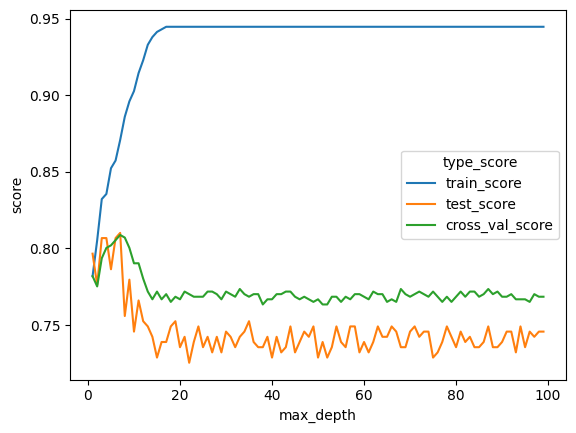

In [146]:
# визуализируем этот датафрейм:

sns.lineplot(data = scores_data, 
             x=scores_data['max_depth'], 
             y=scores_data['score'], 
             hue = 'type_score', 
             #style="type_score", 
             legend='full')


In [156]:
# теперь определим при какой глубине достигался максимальный score на более точной кросс-валидации:

# сначала отберем только type_score == cross_val_score:
only_cross_val_scores = scores_data[(scores_data['type_score'] == 'cross_val_score')]

only_cross_val_scores

,max_depth,type_score,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.775238
200,3,cross_val_score,0.793627
201,4,cross_val_score,0.800364
202,5,cross_val_score,0.802045
...,...,...,...
292,95,cross_val_score,0.766835
293,96,cross_val_score,0.765154
294,97,cross_val_score,0.770196
295,98,cross_val_score,0.768515


In [157]:
# теперь найдем максимальное среди only_cross_val_scores:

only_cross_val_scores['score'].max()

0.8087955182072829

In [158]:
# какой глубине обучения это соответствует???

only_cross_val_scores[only_cross_val_scores['score'] == only_cross_val_scores['score'].max()]

,max_depth,type_score,score
204,7,cross_val_score,0.808796


In [159]:
# сейчас уже зная глубину обучения при которой получается лучший scor на кросс-валидации:

# можно сделать классификатор для train уже с этой глубиной:

best_clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)

In [161]:
# теперь этот классификатор можно проверить на тестовых данных:

cross_val_score(best_clf, X_test, y_test, cv = 5).mean()

0.8169491525423729

# Задача

In [ ]:
# Скачайте тренировочный датасэт с ирисами, обучите деревья с глубиной от 1 до 100. 
# Целевой переменной при обучении является переменная species. 

# При этом записывайте его скор (DecisionTreeClassifier.score()) на 
# тренировочных данных, и аккуратность предсказаний (accuracy_score) на тестовом датасэте. 

# Затем визуализируйте зависимость скора и аккуратности предсказаний от 
# глубины дерева и выберите правильную визуализацию из предложенных.

# Важно: задайте random seed прямо перед созданием дерева или укажите его в параметрах дерева (random_state=rs)

# np.random.seed(0)
# my_awesome_tree = DecisionTreeClassifier(...)

# или

# my_awesome_tree = DecisionTreeClassifier(random_state=0, ...)


# немного сбило с толку то, что в условии будто бы разделяются виды метрик, 
# считаемых для тренировочной и тестовой выборки, которые называют 
# score и accuracy_score. Но стандартная функция tree.DecisionTreeClassifier.score()
# считает именно accuracy_score, поэтому и на тестовой выборке и на 
# тренировочной выборке мы считаем долю верных предсказаний нашей модели, 
# международный термин -- accuracy_score.

In [ ]:
# Файлы:

# train_iris.csv 

# test_iris.csv

In [145]:
train = pd.read_csv('train_iris.csv')

In [146]:
test = pd.read_csv('test_iris.csv')

In [147]:
X_test = test[['sepal length', 'sepal width', 'petal length', 'petal width']]
y_test = test['species']

In [7]:
train = train.drop(['Unnamed: 0'], axis = 1)

In [8]:
train

,sepal length,sepal width,petal length,petal width,species
0,7.4,2.8,6.1,1.9,2
1,5.0,3.4,1.5,0.2,0
2,4.8,3.4,1.6,0.2,0
3,5.8,2.7,5.1,1.9,2
4,7.2,3.6,6.1,2.5,2
...,...,...,...,...,...
95,6.5,3.0,5.2,2.0,2
96,6.7,3.3,5.7,2.1,2
97,6.3,2.7,4.9,1.8,2
98,6.3,2.5,5.0,1.9,2


In [9]:
train.columns

Index(['sepal length', 'sepal width', 'petal length', 'petal width',
       'species'],
      dtype='object')

In [148]:
X_train = train[['sepal length', 'sepal width', 'petal length', 'petal width']]
y_train = train['species']

In [99]:
X_train

,sepal length,sepal width,petal length,petal width
0,7.4,2.8,6.1,1.9
1,5.0,3.4,1.5,0.2
2,4.8,3.4,1.6,0.2
3,5.8,2.7,5.1,1.9
4,7.2,3.6,6.1,2.5
...,...,...,...,...
95,6.5,3.0,5.2,2.0
96,6.7,3.3,5.7,2.1
97,6.3,2.7,4.9,1.8
98,6.3,2.5,5.0,1.9


In [149]:
# Создаем дерево:
np.random.seed(0)
clf = tree.DecisionTreeClassifier(criterion = 'entropy')

In [115]:
# и обучаем его:

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [116]:
clf.score(X_train, y_train)

1.0

In [150]:
# обучаем деревья с глубиной от 1 до 100:

range_depth = range(1,100)

In [156]:
df = pd.DataFrame()

In [152]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics as skm

In [157]:
rs = np.random.seed(0)
for depth in range_depth:
    
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=depth, random_state=rs)
    clf.fit(X_train,y_train)
    
    
    # И ЕЩЕ ДОБАВЛЯЕМ cross_val_score ДЛЯ КАЖДОЙ ГЛУБИНЫ ДЕРЕВА CLF:
    cross_val = cross_val_score(clf, X_train, y_train, cv = 5).mean()
    
    
    

    accurancy = skm.accuracy_score(clf.predict(X_test), y_test)
    
    tmp_df = pd.DataFrame({'max_depth': [depth], 
                           'train_score': [clf.score(X_train, y_train)], 
                           'test_score': [clf.score(X_test, y_test)],
                          'cross_val_score': [cross_val],
                          'accurancy': [accurancy]} )
    
    df = pd.concat([df,tmp_df])

In [158]:
df

,max_depth,train_score,test_score,cross_val_score,accurancy
0,1,0.70,0.60,0.70,0.60
0,2,0.97,0.94,0.95,0.94
0,3,0.99,0.94,0.96,0.94
0,4,1.00,0.94,0.96,0.94
0,5,1.00,0.92,0.96,0.92
...,...,...,...,...,...
0,95,1.00,0.92,0.96,0.92
0,96,1.00,0.92,0.96,0.92
0,97,1.00,0.92,0.96,0.92
0,98,1.00,0.94,0.96,0.94


In [170]:
# сделаем melt таблицы чтобы группировать hue при визуализации:

df = pd.melt(df, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score', 'accurancy'],
        var_name='train_test_val', value_name='score')

In [169]:
df

,max_depth,train_test_val,score
0,1,train_score,0.70
1,2,train_score,0.97
2,3,train_score,0.99
3,4,train_score,1.00
4,5,train_score,1.00
...,...,...,...
391,95,accurancy,0.92
392,96,accurancy,0.92
393,97,accurancy,0.92
394,98,accurancy,0.94


<Axes: xlabel='max_depth', ylabel='score'>

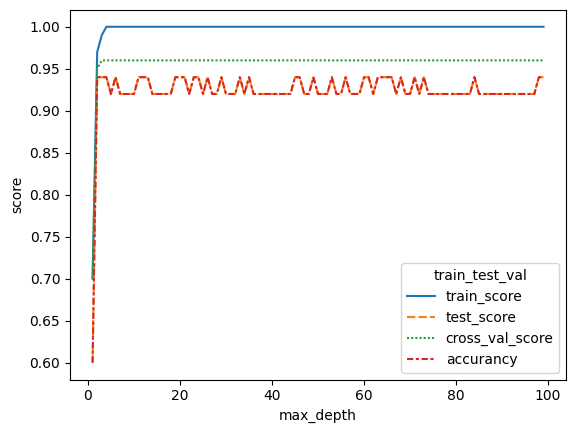

In [172]:
sns.lineplot(data=df, x="max_depth", y="score", hue="train_test_val", style = 'train_test_val')